In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import pandas as pd

import time
import PIL.Image as Image
from IPython.display import Image, display
import matplotlib.cm as cm



In [2]:
data_dir = os.path.join(os.curdir, '/Users/mervetomen/Downloads/Projekt_ADS/bottlesandcanstwo')
                        
BATCH_SIZE = 32
IMG_SIZE = (192, 192)

train_dataset = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE,
                                                            shuffle=True,
                                                            seed=999,
                                                            validation_split=0.20,
                                                            subset = "training")

validation_dataset = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE,
                                                            shuffle=True,
                                                            seed=999,
                                                            validation_split=0.20,
                                                            subset = "validation")

Found 1071 files belonging to 2 classes.
Using 857 files for training.
Found 1071 files belonging to 2 classes.
Using 214 files for validation.


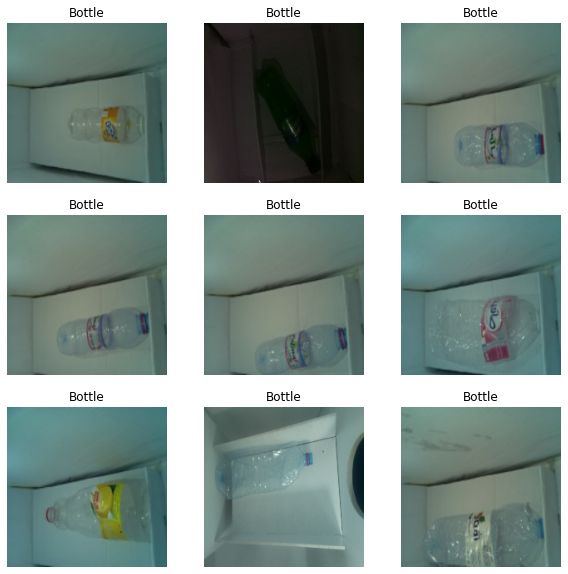

In [3]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [4]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
val_dataset = validation_dataset.skip(val_batches // 5)

In [5]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 7
Number of test batches: 1


In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [7]:
with tf.device('/cpu:0'):
    data_augmentation = tf.keras.Sequential([
      tf.keras.layers.RandomFlip('horizontal'),
      tf.keras.layers.RandomRotation(0.2),
    ])

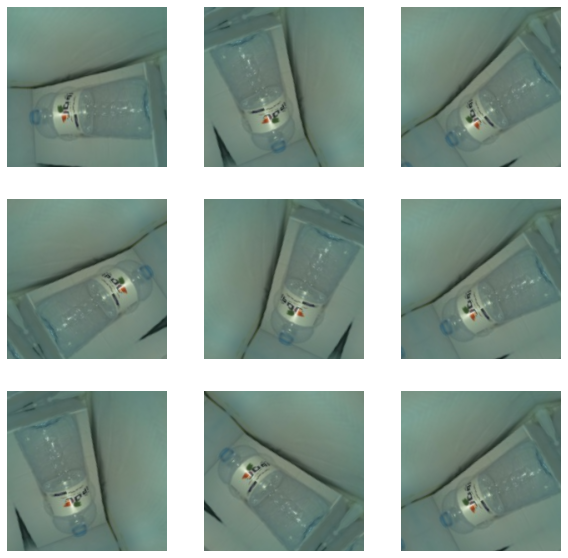

In [8]:
with tf.device('/cpu:0'):
    for image, _ in train_dataset.take(1):
      plt.figure(figsize=(10, 10))
      first_image = image[0]
      for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

### Choose Transfer Learning Model 

As a first execution of the notebook, we will use the following pre-trained model: **MobileNetV2** developed by Google (dowloaded via  `tf.keras.applications.MobileNetV2` ). This will be your base model. The big advantage is that it was trained on ImageNet data! So 1.4M images :) with a wide variety of categories like `jackfruit` and `syringe`. Not on smiles though...Will this help us in recognizing smiles??

Note: Every model was trained using specific image preprocessing requirements. YOU NEED TO CHECK EACH TIME WHAT PECULIAR OF A SPECIFIC MODEL!
Here the guide for MobileNetV2 https://keras.io/api/applications/mobilenet/.

This model expects pixel values in `[-1, 1]`, but at this point, the pixel values in your images are in `[0, 255]`. 
At best, you always use the preprocessing method included with the model.

In [9]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [10]:
#rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [11]:
# Create the base model from the pre-trained model MobileNet V2

IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [12]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 6, 6, 1280)


a. Freeze weights, use the feature extraction as it is, attach a new classification head
In this step, you will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally, you add a classifier on top of it and train the top-level classifier.

It is important to freeze the convolutional base before you compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's trainable flag to False will freeze all of them.

In [13]:
base_model.trainable = False

In [14]:
base_model.summary()

Model: "mobilenetv2_1.00_192"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 192, 192, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 96, 96, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 96, 96, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 96, 96, 32)   0           ['bn_Conv1[0][

Let's now combine this model with a classification head, meaning some fully connected layers (tf.keras.layers.Dense).
Build a model by chaining together the data augmentation, preproccesing, base_model and classification layers (note that the syntax is slighly different, we are using the [Keras Functional API]).

Apply a tf.keras.layers.Dense layer to convert these features into a single prediction per image. You don't need an activation function here because this prediction will be treated as a logit, or a raw prediction value. Positive numbers predict class 1, negative numbers predict class 0.

In [15]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False) #We need to set `training=False` as our model contains a `BatchNormalization` layer. More explanation here https://www.tensorflow.org/guide/keras/transfer_learning
x = tf.keras.layers.GlobalAveragePooling2D()(x) #this layer has the same purpose as tf.keras.layers.Flatten(). Need to connect something 2D to something 1D. Ask if you want to know more :)
#x = tf.keras.layers.Dense(10, activation="relu")(x)
#x = tf.keras.layers.Dropout(0.2)(x)
#x = tf.keras.layers.Dense(5, activation="relu")(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x) 
model = tf.keras.Model(inputs, outputs)

Compile the model before training it. Since there are two classes, use the tf.keras.losses.BinaryCrossentropy loss with from_logits=True since the model provides a linear output.

In [16]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [17]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 192, 192, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 192, 192, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 192, 192, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 192, 192, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_192 (Funct  (None, 6, 6, 1280)       2257984   
 ional)                                                          
                                                             

Above you see how many parameters you are actually training, and how many are frozen.

Train the model

In [18]:
initial_epochs = 19

loss0, accuracy0 = model.evaluate(validation_dataset)

7/7 [==============================] - 9s 862ms/step - loss: 0.3525 - accuracy: 0.9299


In [19]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.35
initial accuracy: 0.93


In [20]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/19
27/27 [==============================] - 27s 836ms/step - loss: 0.2941 - accuracy: 0.9288 - val_loss: 0.2256 - val_accuracy: 0.9486
Epoch 2/19
27/27 [==============================] - 20s 695ms/step - loss: 0.2478 - accuracy: 0.9452 - val_loss: 0.2034 - val_accuracy: 0.9486
Epoch 3/19
27/27 [==============================] - 19s 694ms/step - loss: 0.2130 - accuracy: 0.9463 - val_loss: 0.1951 - val_accuracy: 0.9486
Epoch 4/19
27/27 [==============================] - 21s 776ms/step - loss: 0.2110 - accuracy: 0.9463 - val_loss: 0.1885 - val_accuracy: 0.9486
Epoch 5/19
27/27 [==============================] - 19s 704ms/step - loss: 0.2011 - accuracy: 0.9463 - val_loss: 0.1831 - val_accuracy: 0.9486
Epoch 6/19
27/27 [==============================] - 19s 692ms/step - loss: 0.1861 - accuracy: 0.9463 - val_loss: 0.1786 - val_accuracy: 0.9486
Epoch 7/19
27/27 [==============================] - 19s 696ms/step - loss: 0.1906 - accuracy: 0.9475 - val_loss: 0.1738 - val_accuracy: 0.9486

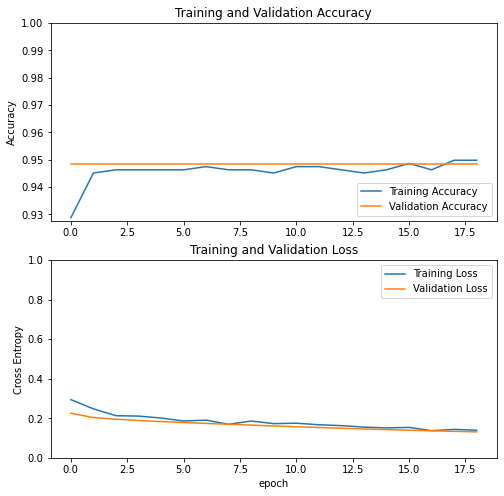

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Note: If you are wondering why the validation metrics are better than the training metrics, the main factor is because layers like tf.keras.layers.BatchNormalization and tf.keras.layers.Dropout affect accuracy during training. They are turned off when calculating validation loss.
To a lesser extent, it is also because training metrics report the average for an epoch, while validation metrics are evaluated after the epoch, so validation metrics see a model that has trained slightly longer.

b) Fine tuning

In [22]:
base_model.trainable = True

In [23]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [24]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [25]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 192, 192, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 192, 192, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 192, 192, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 192, 192, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_192 (Funct  (None, 6, 6, 1280)       2257984   
 ional)                                                          
                                                             

In [26]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 19/29
27/27 [==============================] - 30s 954ms/step - loss: 0.1235 - accuracy: 0.9545 - val_loss: 0.0878 - val_accuracy: 0.9486
Epoch 20/29
27/27 [==============================] - 26s 929ms/step - loss: 0.0906 - accuracy: 0.9662 - val_loss: 0.0774 - val_accuracy: 0.9673
Epoch 21/29
27/27 [==============================] - 25s 912ms/step - loss: 0.0582 - accuracy: 0.9778 - val_loss: 0.0501 - val_accuracy: 0.9720
Epoch 22/29
27/27 [==============================] - 30s 1s/step - loss: 0.0440 - accuracy: 0.9860 - val_loss: 0.0550 - val_accuracy: 0.9673
Epoch 23/29
27/27 [==============================] - 28s 976ms/step - loss: 0.0418 - accuracy: 0.9848 - val_loss: 0.0272 - val_accuracy: 0.9953
Epoch 24/29
27/27 [==============================] - 25s 916ms/step - loss: 0.0401 - accuracy: 0.9860 - val_loss: 0.0221 - val_accuracy: 0.9953
Epoch 25/29
27/27 [==============================] - 26s 950ms/step - loss: 0.0221 - accuracy: 0.9953 - val_loss: 0.0323 - val_accuracy: 0.

In [27]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

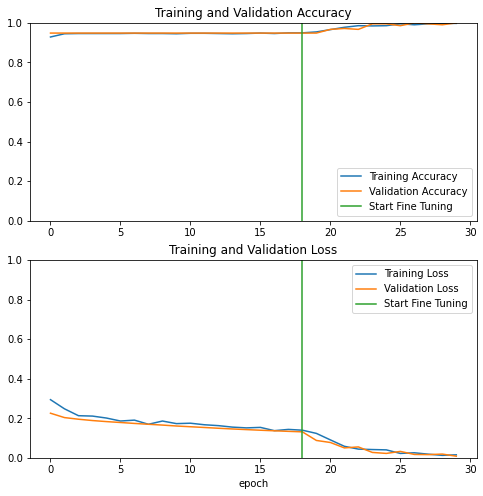

In [28]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Evaluation and prediction

In [29]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

1/1 [==============================] - 1s 1s/step - loss: 0.0021 - accuracy: 1.0000
Test accuracy : 1.0


Predictions:
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
Labels:
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]


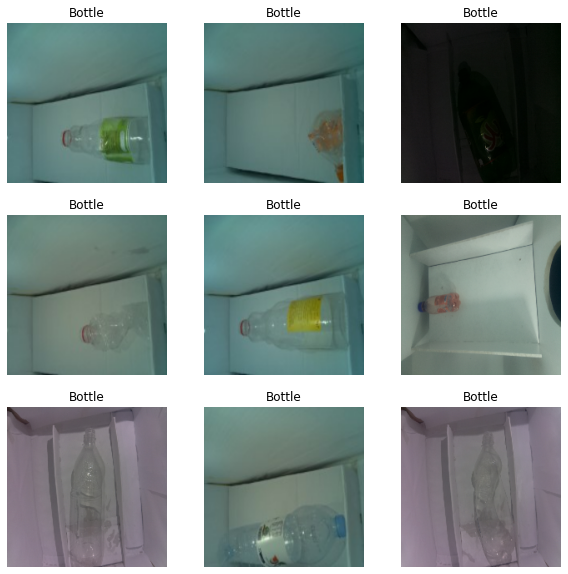

In [30]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

4. Test with your own selfie :)

This image most likely belongs to Bottle.


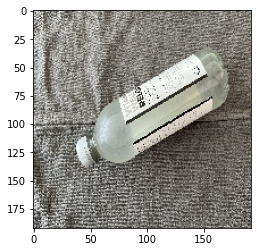

In [103]:
img = tf.keras.utils.load_img("IMG_8956.jpg", target_size=(192,192)
)

img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Add the image to a batch where it's the only member.


prediction = model.predict_on_batch(img_array).flatten()

prediction = tf.where(prediction < 0.5, 0, 1)


print(
    "This image most likely belongs to {}."
    .format(class_names[prediction[0]])
)

plt.imshow(img)